In [52]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from math import floor, ceil, sqrt
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
from os.path import exists as DoesPathExist
train_logs_path = "/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv"
train_scores_path = "/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv"
test_logs_path = "/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv"
sample_submission_path = "/kaggle/input/linking-writing-processes-to-writing-quality/sample_submission.csv"

if DoesPathExist(train_logs_path):
    train_logs: pd.DataFrame = pd.read_csv(train_logs_path)
else:
    train_logs: pd.DataFrame = pd.read_csv("./data/train_logs.csv")

if DoesPathExist(train_scores_path):
    train_scores = pd.read_csv(train_scores_path)
else:
    train_scores = pd.read_csv("./data/train_scores.csv")

if DoesPathExist(test_logs_path):
    test_logs = pd.read_csv(test_logs_path)
else:
    test_logs = pd.read_csv("./data/test_logs.csv")
    
if DoesPathExist(sample_submission_path):
    sample_submission = pd.read_csv(sample_submission_path)
else:
    sample_submission = pd.read_csv("./data/sample_submission.csv")
    
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('expand_frame_repr', False)

# Data preprocessing

##### Training Prep

In [53]:
PUNCUATION = ['!', '"', "'", '(', ')', ',', '.', ':', ';','?', '¡', '¿', '\\']
MAX_EVENT_START_TIME = 1_800_000 # miliseconds in 30 minutes.
NUMBER_OF_INTERVALS = 1_800 # = 1_800_000 msec / 250 milisecond intervals

NUM_FEATURES = 10
NUM_FEATURES_2 = 52
FINAL_LAYER_COUNT = 12

MAX_ACTION_TIME = 250
WORD_MAX = 800 # This is to divide all the word counts so that word count is still roughly 0-1 but keeps word count differentiable between papers.
EVENT_MAX = 6000 # Keeps Max number of event relavent but between 0-1 ish.
FIRST_DOWN_TIME_DIVISOR = 60_000
ACTIVITY_COUNT_DIVISOR = 6000
INSERT_COUNT_DIVISOR = 6000
REMOVAL_COUNT_DIVISOR = 700
PASTE_COUNT_DIVISOR = 10
REPLACE_COUNT_DIVISOR = 10
SHIFT_COUNT_DIVISOR = 300
PUNCUATION_COUNT_DIVISOR = 100
SPACE_COUNT_DIVISOR = 1000
MOVEMENT_COUNT_DIVISOR = 250


def ScoreOneHot(score: float) -> np.array:
    result = np.zeros(12)
    result[int(score / 0.5) - 1] = 1
    return result
    

def TrainingPrep(df: pd.DataFrame):

    indexs_to_drop = df[df["down_time"] > df.down_time.quantile(0.999)].index
    df.drop(indexs_to_drop, inplace=True)
    indexs_to_drop = df[df["up_time"] > df.down_time.quantile(0.999)].index
    df.drop(indexs_to_drop, inplace=True)

    return df

def DfToX(df: pd.DataFrame, score: float = None) -> np.array:
    indexs_to_drop = df[df["action_time"] > MAX_ACTION_TIME].index
    df = df.drop(indexs_to_drop, axis=0)

    NumUniqueIds = len(np.unique(df["id"]))
    x_train_1 = np.zeros((NumUniqueIds, NUM_FEATURES, int(NUMBER_OF_INTERVALS)))
    x_train_2 = np.zeros((NumUniqueIds, NUM_FEATURES_2))
    #y_train = np.zeros((NumUniqueIds, FINAL_LAYER_COUNT))
    y_train = np.zeros(NumUniqueIds)
    
    groups = df.groupby("id")

    for index, id in enumerate(np.unique(df["id"])):
        if score is not None:
            #y_train[index] = ScoreOneHot(score)
            y_train[index] = np.float32(score)


        essayGroup = groups.get_group(id)
        max = essayGroup["down_time"].quantile(0.99)
        min = essayGroup["down_time"].quantile(0.01)
        dt_range = max - min
        if dt_range == 0:
            dt_range = 1
        if dt_range is None:
            dt_range = 1

        MAX_CURSOR_POSITION = essayGroup["cursor_position"].max()

        if MAX_CURSOR_POSITION is None:
            print("MAX_CURSOR_POSITION is None")

        ValueActivityCounts = essayGroup.activity.value_counts().reset_index()
        ValueEventCounts = essayGroup.down_event.value_counts().reset_index()
        ValueTextChangeCounts = essayGroup.text_change.value_counts().reset_index()

        SpaceStats = essayGroup[["id", "down_event", "event_id"]]
        SpaceStats = SpaceStats[SpaceStats["down_event"].isin(["Space"])]
        SpaceStats["word_size"] = SpaceStats["event_id"].diff()
        SpaceStats = SpaceStats.dropna(axis=0).reset_index()

        x_train_2[index][0] = essayGroup.word_count.max() / WORD_MAX
        x_train_2[index][1] = essayGroup.event_id.max() / EVENT_MAX
        x_train_2[index][2] = essayGroup.down_time.min() / FIRST_DOWN_TIME_DIVISOR

        x_train_2[index][3] = essayGroup.activity.count() / ACTIVITY_COUNT_DIVISOR
        x_train_2[index][4] = ValueActivityCounts[ValueActivityCounts["activity"] == "Input"]["count"].max() / INSERT_COUNT_DIVISOR
        x_train_2[index][5] = ValueActivityCounts[ValueActivityCounts["activity"] == "Remove/Cut"]["count"].max() / REMOVAL_COUNT_DIVISOR
        x_train_2[index][6] = ValueActivityCounts[ValueActivityCounts["activity"] == "Paste"]["count"].max() / PASTE_COUNT_DIVISOR
        x_train_2[index][7] = ValueActivityCounts[ValueActivityCounts["activity"] == "Replace"]["count"].max() / REPLACE_COUNT_DIVISOR

        x_train_2[index][9] = ValueEventCounts[ValueEventCounts["down_event"] == "Shift"]["count"].max() / SHIFT_COUNT_DIVISOR
        x_train_2[index][10] = ValueEventCounts[ValueEventCounts["down_event"].isin(PUNCUATION)]["count"].sum() / PUNCUATION_COUNT_DIVISOR
        x_train_2[index][11] = ValueEventCounts[ValueEventCounts["down_event"].isin(["Space", "CapsLock"])]["count"].sum() / SPACE_COUNT_DIVISOR
        x_train_2[index][12] = ValueEventCounts[ValueEventCounts["down_event"].isin(["Leftclick", "ArrowUp", "ArrowDown", "ArrowLeft", "ArrowRight"])]["count"].sum() / MOVEMENT_COUNT_DIVISOR
        x_train_2[index][25] = ValueEventCounts[ValueEventCounts["down_event"].isin(["?", "!"])]["count"].sum() / 10

        x_train_2[index][14] = essayGroup.action_time.mean() / 100
        x_train_2[index][15] = essayGroup.action_time.sum() / 500_000
        x_train_2[index][16] = essayGroup.action_time.std() / 100
        x_train_2[index][17] = essayGroup.action_time.skew() / 20

        x_train_2[index][13] = essayGroup.down_time.mean() / 100_000
        x_train_2[index][18] = essayGroup.down_time.sum() / 100_000_000
        x_train_2[index][19] = essayGroup.down_time.std() / 500_000
        x_train_2[index][20] = essayGroup.down_time.skew() / 20
        x_train_2[index][21] = essayGroup.down_time.sem() / 10_000

        x_train_2[index][22] = essayGroup.word_count.std() / 200
        x_train_2[index][23] = essayGroup.word_count.sem() / 3
        x_train_2[index][24] = essayGroup.word_count.mean() / 350

        for i in range(10):
            if i == 0 or i == 1:
                x_train_2[index][26+i] = essayGroup[essayGroup.action_time >= (i+1)*50].action_time.count() / 2500
            elif i == 2 or i == 3:
                x_train_2[index][26+i] = essayGroup[essayGroup.action_time >= (i+1)*50].action_time.count() / 500
            else:
                x_train_2[index][26+i] = essayGroup[essayGroup.action_time >= (i+1)*50].action_time.count() / 25

        x_train_2[index][36] = ValueEventCounts[ValueEventCounts["down_event"].isin(["AudioVolumeDown", "AudioVolumeMute", "AudioVolumeUp", "MediaPlayPause", "MediaTrackNext", "MediaTrackPrevious"])]["count"].sum() / 10
        x_train_2[index][37] = ValueTextChangeCounts[ValueTextChangeCounts["text_change"].isin(["q"])]["count"].sum() / 1000
        x_train_2[index][38] = ValueTextChangeCounts[ValueTextChangeCounts["text_change"].isin([" ", "\n"])]["count"].sum() / 1000
        x_train_2[index][38] = ValueTextChangeCounts[ValueTextChangeCounts["text_change"].isin(["NoChange"])]["count"].sum() / 500
        x_train_2[index][39] = ValueTextChangeCounts[ValueTextChangeCounts["text_change"].isin(["NoChange", " ", "\n", "q"])]["count"].sum() / 500
        x_train_2[index][40] = np.sum(list(map(lambda x: x.count("=>"), essayGroup['text_change'])))

        temp_diff = essayGroup.groupby("id")["down_time"].diff(periods=1, axis=0)   
        x_train_2[index][41] = essayGroup[temp_diff > 100].dropna().groupby("id")["event_id"].count().max() / 4000
        x_train_2[index][42] = essayGroup[temp_diff > 1_000].dropna().groupby("id")["event_id"].count().max() / 200
        x_train_2[index][43] = essayGroup[temp_diff > 10_000].dropna().groupby("id")["event_id"].count().max() / 20
        x_train_2[index][43] = essayGroup[temp_diff > 10_000].dropna().groupby("id")["event_id"].count().max() / 20
        x_train_2[index][44] = essayGroup[temp_diff > 100_000].dropna().groupby("id")["event_id"].count().max() / 2
        del temp_diff

        x_train_2[index][45] = SpaceStats.word_size.mean() / 10
        x_train_2[index][46] = SpaceStats.word_size.sum() / 6000
        x_train_2[index][47] = SpaceStats.word_size.skew() / 10
        x_train_2[index][48] = SpaceStats.word_size.std() / 15
        x_train_2[index][49] = SpaceStats.word_size.sem() # / 1

        x_train_2[index][50] = np.sum(list(map(lambda x: x.count("Move From"), essayGroup['activity'])))
        x_train_2[index][51] = ValueActivityCounts[ValueActivityCounts["activity"] == "Nonproduction"]["count"].max() / 500

        for i in range(len(x_train_2[index])):
            if np.isnan(x_train_2[index][i]):
                x_train_2[index][i] = 0

        x_train_2[index][8] = ((x_train_2[index][7] * REPLACE_COUNT_DIVISOR) + (x_train_2[index][6] * PASTE_COUNT_DIVISOR)) / (PASTE_COUNT_DIVISOR + REPLACE_COUNT_DIVISOR)
        if np.isnan(x_train_2[index][8]):
            x_train_2[index][8] = 0

        # Build X Train 1 (convolution)
        for row in essayGroup.itertuples():

            if (row.down_time < min*0.9) or (row.down_time > max*1.1):
                continue

            start_index = floor(((row.down_time - min) / dt_range) * NUMBER_OF_INTERVALS)

            if start_index >= NUMBER_OF_INTERVALS:
                start_index = NUMBER_OF_INTERVALS - 1

            if start_index < 0:
                start_index = 0
            
            match row.activity:
                case "Nonproduction":
                    x_train_1[index][2][start_index] += 1.0
                case "Input" | "Replace":
                    # Puncuation
                    if row.down_event in PUNCUATION:
                        x_train_1[index][6][start_index] += 1.0
                    elif row.down_event == "q":
                        x_train_1[index][7][start_index] += 1.0
                    else:
                        x_train_1[index][8][start_index] += 1.0

                case "Remove/Cut":
                    x_train_1[index][4][start_index] += 1.0
                case "Paste":
                    x_train_1[index][5][start_index] += 1.0
                case _:
                    if "Move From" in row.activity:
                        x_train_1[index][3][start_index] += 1.0
            
            if x_train_1[index][0][start_index] < (row.word_count / WORD_MAX):
                x_train_1[index][0][start_index] = (row.word_count / WORD_MAX)
            
            if x_train_1[index][1][start_index] < (row.cursor_position / MAX_CURSOR_POSITION):
                x_train_1[index][1][start_index] = (row.cursor_position / MAX_CURSOR_POSITION)
            
            if x_train_1[index][9][start_index] < (row.event_id / EVENT_MAX):
                x_train_1[index][9][start_index] = (row.event_id / EVENT_MAX)
        
        currentWordCount = 0
        for i, wordCount in enumerate(np.nditer(x_train_1[index][0])):
            if wordCount == 0:
                x_train_1[index][0] = currentWordCount
            elif currentWordCount != wordCount:
                currentWordCount = wordCount

        currentCursorPosition = 0
        for i, cursor in enumerate(np.nditer(x_train_1[index][1])):
            if cursor == 0:
                x_train_1[index][1] = currentCursorPosition
            elif cursor != currentCursorPosition:
                currentCursorPosition = cursor

        currentEventCount = 0
        for i, event in enumerate(np.nditer(x_train_1[index][1])):
            if event == 0:
                x_train_1[index][9] = currentEventCount
            elif event != currentEventCount:
                currentEventCount = event
                
    x_train_1 = np.transpose(x_train_1, axes=(0, 2, 1))
    return x_train_1, x_train_2, y_train

def GenerateNewExample(x_train: np.array):
    example_index = np.random.choice(len(x_train), 1)[0]
    Noise = (0.005 * np.random.sample(x_train[0].shape)) - 0.0025
    result = x_train[example_index] *  (1 + Noise)
    return result

In [54]:
TrainingPrep(train_logs)

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1
...,...,...,...,...,...,...,...,...,...,...,...
8405893,fff05981,3615,2063944,2064440,496,Nonproduction,Leftclick,Leftclick,NoChange,1031,240
8405894,fff05981,3616,2064497,2064497,0,Nonproduction,Shift,Shift,NoChange,1031,240
8405895,fff05981,3617,2064657,2064765,108,Replace,q,q,q => q,1031,240
8405896,fff05981,3618,2069186,2069259,73,Nonproduction,Leftclick,Leftclick,NoChange,1028,240


#### Splitting the Function

In [55]:
LOW_UPPER = 2.0
MED_UPPER = 5.0

In [56]:
x_test = np.zeros((0, int(NUMBER_OF_INTERVALS), NUM_FEATURES))
x_test_2 = np.zeros((0, NUM_FEATURES_2))
y_test = np.zeros(0)

x_train_low = np.zeros((0, int(NUMBER_OF_INTERVALS), NUM_FEATURES))
x_train_low_2 = np.zeros((0, NUM_FEATURES_2))
x_train_med = np.zeros((0, int(NUMBER_OF_INTERVALS), NUM_FEATURES))
x_train_med_2 = np.zeros((0, NUM_FEATURES_2))
x_train_high = np.zeros((0, int(NUMBER_OF_INTERVALS), NUM_FEATURES))
x_train_high_2 = np.zeros((0, NUM_FEATURES_2))

y_train_low = np.zeros(0)
y_train_med = np.zeros(0)
y_train_high = np.zeros(0)

x_valid_low = np.zeros((0, int(NUMBER_OF_INTERVALS), NUM_FEATURES))
x_valid_low_2 = np.zeros((0, NUM_FEATURES_2))
x_valid_med = np.zeros((0, int(NUMBER_OF_INTERVALS), NUM_FEATURES))
x_valid_med_2 = np.zeros((0, NUM_FEATURES_2))
x_valid_high = np.zeros((0, int(NUMBER_OF_INTERVALS), NUM_FEATURES))
x_valid_high_2 = np.zeros((0, NUM_FEATURES_2))

y_valid_low = np.zeros(0)
y_valid_med = np.zeros(0)
y_valid_high = np.zeros(0)

# Low 0.5 - 2.5
for x in range(1, 13):
    print(x)
    if x/2 <= LOW_UPPER:
        NUM_EXAMPLES_UPPER_LIMIT = 2000
        NUM_EXAMPLES_LOWER_LIMIT = 15
    elif x/2 <= MED_UPPER:
        NUM_EXAMPLES_UPPER_LIMIT = 2000
        NUM_EXAMPLES_LOWER_LIMIT = 200
    else:
        NUM_EXAMPLES_UPPER_LIMIT = 2000
        NUM_EXAMPLES_LOWER_LIMIT = 50

    ids = train_scores[train_scores["score"] == (x/2)]
    temp_train_x_1, temp_train_x_2, temp_train_y = DfToX(train_logs[train_logs["id"].isin(ids.id)], x/2)

    if len(temp_train_x_1) > NUM_EXAMPLES_UPPER_LIMIT:
        indicies_to_remove = np.random.choice(len(temp_train_x_1), len(temp_train_x_1) - NUM_EXAMPLES_UPPER_LIMIT, replace=False)
        temp_train_x_1 = np.delete(temp_train_x_1, indicies_to_remove, 0)
        temp_train_x_2 = np.delete(temp_train_x_2, indicies_to_remove, 0)
        temp_train_y = temp_train_y[:NUM_EXAMPLES_UPPER_LIMIT]

    while len(temp_train_x_1) < NUM_EXAMPLES_LOWER_LIMIT:
        randomExample1 = GenerateNewExample(x_train=temp_train_x_1)
        randomExample2 = GenerateNewExample(x_train=temp_train_x_2)
        temp_train_x_1 = np.concatenate((temp_train_x_1, [randomExample1]))
        temp_train_x_2 = np.concatenate((temp_train_x_2, [randomExample2]))
        temp_train_y = np.concatenate((temp_train_y, [temp_train_y[0]]))

    first_cutoff = floor(0.2 * len(temp_train_x_1))
    second_cutoff = first_cutoff * 2

    x_test = np.append(x_test, temp_train_x_1[:first_cutoff], axis=0)
    x_test_2 = np.append(x_test_2, temp_train_x_2[:first_cutoff], axis=0)
    y_test = np.append(y_test, temp_train_y[:first_cutoff], axis=0)
    
    if x/2 <= LOW_UPPER: #Low Cutoff
        x_valid_low = np.append(x_valid_low, temp_train_x_1[first_cutoff:second_cutoff], axis=0)
        x_train_low = np.append(x_train_low, temp_train_x_1[second_cutoff:], axis=0)
        x_valid_low_2 = np.append(x_valid_low_2, temp_train_x_2[first_cutoff:second_cutoff], axis=0)
        x_train_low_2 = np.append(x_train_low_2, temp_train_x_2[second_cutoff:], axis=0)
        y_valid_low = np.append(y_valid_low, temp_train_y[first_cutoff:second_cutoff], axis=0)
        y_train_low = np.append(y_train_low, temp_train_y[second_cutoff:], axis=0)
    elif x/2 <= MED_UPPER: # Med Cutoff
        x_valid_med = np.append(x_valid_med, temp_train_x_1[first_cutoff:second_cutoff], axis=0)
        x_train_med = np.append(x_train_med, temp_train_x_1[second_cutoff:], axis=0)
        x_valid_med_2 = np.append(x_valid_med_2, temp_train_x_2[first_cutoff:second_cutoff], axis=0)
        x_train_med_2 = np.append(x_train_med_2, temp_train_x_2[second_cutoff:], axis=0)
        y_valid_med = np.append(y_valid_med, temp_train_y[first_cutoff:second_cutoff], axis=0)
        y_train_med = np.append(y_train_med, temp_train_y[second_cutoff:], axis=0)
    else:
        x_valid_high = np.append(x_valid_high, temp_train_x_1[first_cutoff:second_cutoff], axis=0)
        x_train_high = np.append(x_train_high, temp_train_x_1[second_cutoff:], axis=0)
        x_valid_high_2 = np.append(x_valid_high_2, temp_train_x_2[first_cutoff:second_cutoff], axis=0)
        x_train_high_2 = np.append(x_train_high_2, temp_train_x_2[second_cutoff:], axis=0)
        y_valid_high = np.append(y_valid_high, temp_train_y[first_cutoff:second_cutoff], axis=0)
        y_train_high = np.append(y_train_high, temp_train_y[second_cutoff:], axis=0)

1
2
3
4
5
6
7
8
9
10
11
12


In [57]:
print(f"Shape of X Train Low: {x_train_low.shape}")
print(f"Shape of X Train Low 2: {x_train_low_2.shape}")
print(f"Shape of Y Train Low: {y_train_low.shape}\n")
print(f"Shape of X Valid Low: {x_valid_low.shape}")
print(f"Shape of X Valid Low 2: {x_valid_low_2.shape}")
print(f"Shape of Y Valid Low: {y_valid_low.shape}\n")
print(f"Shape of X Train Med: {x_train_med.shape}")
print(f"Shape of X Train Med 2: {x_train_med_2.shape}")
print(f"Shape of Y Train Med: {y_train_med.shape}\n")
print(f"Shape of X Valid Med: {x_valid_med.shape}")
print(f"Shape of X Valid Med 2: {x_valid_med_2.shape}")
print(f"Shape of Y Valid Med: {y_valid_med.shape}\n")
print(f"Shape of X Train High: {x_train_high.shape}")
print(f"Shape of X Train High 2: {x_train_high_2.shape}")
print(f"Shape of Y Train High: {y_train_high.shape}\n")
print(f"Shape of X Valid High: {x_valid_high.shape}")
print(f"Shape of X Valid High 2: {x_valid_high_2.shape}")
print(f"Shape of Y Valid High: {y_valid_high.shape}\n")

Shape of X Train Low: (129, 1800, 10)
Shape of X Train Low 2: (129, 52)
Shape of Y Train Low: (129,)

Shape of X Valid Low: (41, 1800, 10)
Shape of X Valid Low 2: (41, 52)
Shape of Y Valid Low: (41,)

Shape of X Train Med: (1277, 1800, 10)
Shape of X Train Med 2: (1277, 52)
Shape of Y Train Med: (1277,)

Shape of X Valid Med: (424, 1800, 10)
Shape of X Valid Med 2: (424, 52)
Shape of Y Valid Med: (424,)

Shape of X Train High: (108, 1800, 10)
Shape of X Train High 2: (108, 52)
Shape of Y Train High: (108,)

Shape of X Valid High: (35, 1800, 10)
Shape of X Valid High 2: (35, 52)
Shape of Y Valid High: (35,)



In [58]:
x_train = np.zeros((0, int(NUMBER_OF_INTERVALS), NUM_FEATURES))
x_train_2 = np.zeros((0, NUM_FEATURES_2))
y_train = np.zeros((0, 3))

x_valid = np.zeros((0, int(NUMBER_OF_INTERVALS), NUM_FEATURES))
x_valid_2 = np.zeros((0, NUM_FEATURES_2))
y_valid = np.zeros((0, 3))

TRAIN_NUM_EXAMPLES_PER_CATEGORY_Train_Low = x_train_low.shape[0]
VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Train_Low = int(TRAIN_NUM_EXAMPLES_PER_CATEGORY_Train_Low * 0.2)
TRAIN_NUM_EXAMPLES_PER_CATEGORY_Valid_Low = x_valid_low.shape[0]
VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Valid_Low = int(TRAIN_NUM_EXAMPLES_PER_CATEGORY_Valid_Low * 0.2)

TRAIN_NUM_EXAMPLES_PER_CATEGORY_Train_Med = x_train_med.shape[0]
VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Train_Med = int(TRAIN_NUM_EXAMPLES_PER_CATEGORY_Train_Med * 0.2)
TRAIN_NUM_EXAMPLES_PER_CATEGORY_Valid_Med = x_valid_med.shape[0]
VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Valid_Med = int(TRAIN_NUM_EXAMPLES_PER_CATEGORY_Valid_Med * 0.2)

TRAIN_NUM_EXAMPLES_PER_CATEGORY_Train_High = x_train_high.shape[0]
VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Train_High = int(TRAIN_NUM_EXAMPLES_PER_CATEGORY_Train_High * 0.2)
TRAIN_NUM_EXAMPLES_PER_CATEGORY_Valid_High = x_valid_high.shape[0]
VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Valid_High = int(TRAIN_NUM_EXAMPLES_PER_CATEGORY_Valid_High * 0.2)

indicies_to_add_low = np.random.choice(len(x_train_low), TRAIN_NUM_EXAMPLES_PER_CATEGORY_Train_Low, replace=False)
indicies_to_add_med = np.random.choice(len(x_train_med), TRAIN_NUM_EXAMPLES_PER_CATEGORY_Train_Med, replace=False)
indicies_to_add_high = np.random.choice(len(x_train_high), TRAIN_NUM_EXAMPLES_PER_CATEGORY_Train_High, replace=False)

# Filling from the training list
for index in indicies_to_add_low[VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Train_Low:]:
    x_train = np.append(x_train, [x_train_low[index]], axis=0)
    x_train_2 = np.append(x_train_2, [x_train_low_2[index]], axis=0)

for index in indicies_to_add_low[:VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Train_Low]:
    x_valid = np.append(x_valid, [x_train_low[index]], axis=0)
    x_valid_2 = np.append(x_valid_2, [x_train_low_2[index]], axis=0)

y_train = np.append(y_train, [[1, 0, 0] for y in range(len(indicies_to_add_low[VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Train_Low:]))], axis=0)
y_valid = np.append(y_valid, [[1, 0, 0] for y in range(len(indicies_to_add_low[:VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Train_Low]))], axis=0)

for index in indicies_to_add_med[VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Train_Med:]:
    x_train = np.append(x_train, [x_train_med[index]], axis=0)
    x_train_2 = np.append(x_train_2, [x_train_med_2[index]], axis=0)

for index in indicies_to_add_med[:VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Train_Med]:
    x_valid = np.append(x_valid, [x_train_med[index]], axis=0)
    x_valid_2 = np.append(x_valid_2, [x_train_med_2[index]], axis=0)

y_train = np.append(y_train, [[0, 1, 0] for y in range(len(indicies_to_add_med[VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Train_Med:]))], axis=0)
y_valid = np.append(y_valid, [[0, 1, 0] for y in range(len(indicies_to_add_med[:VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Train_Med]))], axis=0)

for index in indicies_to_add_high[VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Train_High:]:
    x_train = np.append(x_train, [x_train_high[index]], axis=0)
    x_train_2 = np.append(x_train_2, [x_train_high_2[index]], axis=0)

for index in indicies_to_add_high[:VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Train_High]:
    x_valid = np.append(x_valid, [x_train_high[index]], axis=0)
    x_valid_2 = np.append(x_valid_2, [x_train_high_2[index]], axis=0)

y_train = np.append(y_train, [[0, 0, 1] for y in range(len(indicies_to_add_high[VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Train_High:]))], axis=0)
y_valid = np.append(y_valid, [[0, 0, 1] for y in range(len(indicies_to_add_high[:VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Train_High]))], axis=0)

# Filling from the valid list
indicies_to_add_low = np.random.choice(len(x_valid_low), TRAIN_NUM_EXAMPLES_PER_CATEGORY_Valid_Low, replace=False)
indicies_to_add_med = np.random.choice(len(x_valid_med), TRAIN_NUM_EXAMPLES_PER_CATEGORY_Valid_Med, replace=False)
indicies_to_add_high = np.random.choice(len(x_valid_high), TRAIN_NUM_EXAMPLES_PER_CATEGORY_Valid_High, replace=False)


for index in indicies_to_add_low[VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Valid_Low:]:
    x_train = np.append(x_train, [x_valid_low[index]], axis=0)
    x_train_2 = np.append(x_train_2, [x_valid_low_2[index]], axis=0)

for index in indicies_to_add_low[:VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Valid_Low]:
    x_valid = np.append(x_valid, [x_valid_low[index]], axis=0)
    x_valid_2 = np.append(x_valid_2, [x_valid_low_2[index]], axis=0)

y_train = np.append(y_train, [[1, 0, 0] for y in range(len(indicies_to_add_low[VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Valid_Low:]))], axis=0)
y_valid = np.append(y_valid, [[1, 0, 0] for y in range(len(indicies_to_add_low[:VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Valid_Low]))], axis=0)

for index in indicies_to_add_med[VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Valid_Med:]:
    x_train = np.append(x_train, [x_valid_med[index]], axis=0)
    x_train_2 = np.append(x_train_2, [x_valid_med_2[index]], axis=0)

for index in indicies_to_add_med[:VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Valid_Med]:
    x_valid = np.append(x_valid, [x_valid_med[index]], axis=0)
    x_valid_2 = np.append(x_valid_2, [x_valid_med_2[index]], axis=0)

y_train = np.append(y_train, [[0, 1, 0] for y in range(len(indicies_to_add_med[VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Valid_Med:]))], axis=0)
y_valid = np.append(y_valid, [[0, 1, 0] for y in range(len(indicies_to_add_med[:VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Valid_Med]))], axis=0)

for index in indicies_to_add_high[VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Valid_High:]:
    x_train = np.append(x_train, [x_valid_high[index]], axis=0)
    x_train_2 = np.append(x_train_2, [x_valid_high_2[index]], axis=0)

for index in indicies_to_add_high[:VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Valid_High]:
    x_valid = np.append(x_valid, [x_valid_high[index]], axis=0)
    x_valid_2 = np.append(x_valid_2, [x_valid_high_2[index]], axis=0)

y_train = np.append(y_train, [[0, 0, 1] for y in range(len(indicies_to_add_high[VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Valid_High:]))], axis=0)
y_valid = np.append(y_valid, [[0, 0, 1] for y in range(len(indicies_to_add_high[:VALID_NUM_EXAMPLES_PER_CATEGORY_CUTOFF_Valid_High]))], axis=0)


In [59]:
print(f"Shape of X Test: {x_test.shape}")
print(f"Shape of X Test 2: {x_test_2.shape}")
print(f"Shape of Y Test: {y_test.shape}\n")
print(f"Shape of X Train: {x_train.shape}")
print(f"Shape of X Train 2: {x_train_2.shape}")
print(f"Shape of Y Train: {y_train.shape}\n")
print(f"Shape of X Valid: {x_valid.shape}")
print(f"Shape of X Valid 2: {x_valid_2.shape}")
print(f"Shape of Y Valid: {y_valid.shape}\n")

Shape of X Test: (500, 1800, 10)
Shape of X Test 2: (500, 52)
Shape of Y Test: (500,)

Shape of X Train: (1614, 1800, 10)
Shape of X Train 2: (1614, 52)
Shape of Y Train: (1614, 3)

Shape of X Valid: (400, 1800, 10)
Shape of X Valid 2: (400, 52)
Shape of Y Valid: (400, 3)



# Models

#### Metrics

In [60]:
metrics_Cat = [tf.keras.metrics.categorical_accuracy] #tf.keras.metrics.categorical_crossentropy
metrics_Single = [tf.keras.metrics.RootMeanSquaredError()]
loss_Cat = tf.keras.losses.CategoricalCrossentropy()
loss_Single = tf.keras.losses.MeanSquaredError()

## Main

#### Layer Creation

In [61]:
def Get_Main_Split_Layer():
    input_shape_1 = x_train[0].shape
    input_shape_2 = x_train_2[0].shape
    print(input_shape_1)
    print(input_shape_2)

    input_1 = tf.keras.Input(shape=input_shape_1, dtype=np.float64)
    input_2 = tf.keras.Input(shape=input_shape_2, dtype=np.float64)

    layers_1 = tf.keras.layers.Normalization()(input_1)
    layers_1 = tf.keras.layers.Conv1D(filters=256, 
                                    kernel_size = (4,), 
                                    strides=2, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=256, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=100, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=80, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Flatten()(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=1024, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=4096, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=2048, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=512, activation='relu')(layers_1)
    model_1 = tf.keras.Model(inputs = input_1, outputs=layers_1)

    layers_2 = tf.keras.layers.Normalization()(input_2)
    layers_2 = tf.keras.layers.Dense(units=NUM_FEATURES_2, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dense(units=128, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=64, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=64, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=512, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.2)(layers_2)
    model_2 = tf.keras.models.Model(inputs = input_2, outputs=layers_2)

    layers_3 = tf.keras.layers.Dense(units=512, activation='relu')(tf.keras.layers.concatenate([model_1.output, model_2.output]))
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=128, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=256, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=512, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=256, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=12, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.2)(layers_3)

    layers_Output = tf.keras.layers.Dense(units=3,activation=tf.keras.activations.sigmoid)(layers_3)
    return model_1.input, model_2.input, layers_Output

Split_1_Input, Split_2_Input, Split_Output = Get_Main_Split_Layer()

modelSplit = None
modelSplit = tf.keras.models.Model(inputs=[Split_1_Input, Split_2_Input], outputs=Split_Output, name="Split")
modelSplit.compile(optimizer='adam', loss=loss_Cat, metrics=metrics_Cat)
modelSplit.summary()

(1800, 10)
(52,)
Model: "Split"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 1800, 10)]           0         []                            
                                                                                                  
 normalization_14 (Normaliz  (None, 1800, 10)             21        ['input_15[0][0]']            
 ation)                                                                                           
                                                                                                  
 conv1d_27 (Conv1D)          (None, 900, 256)             10496     ['normalization_14[0][0]']    
                                                                                                  
 max_pooling1d_27 (MaxPooli  (None, 450, 256)             0         ['conv1d_

#### Training

In [62]:
SplitProportionalControl = (170 + 1592 + 143) / 3
WeightSplit = {0: (1 / 170) * SplitProportionalControl, 1: (1 / 1592) * SplitProportionalControl, 2: (1 / 143) * SplitProportionalControl}
print(WeightSplit)
epochs = 50 #55
history = modelSplit.fit(x=[x_train, x_train_2], y=y_train, validation_data=([x_valid, x_valid_2], y_valid), epochs=epochs, class_weight=WeightSplit)

{0: 3.735294117647059, 1: 0.39886934673366836, 2: 4.440559440559441}
Epoch 1/50
51/51 [==============================] - 9s 164ms/step - loss: 3.7030 - categorical_accuracy: 0.2900 - val_loss: 2.0551 - val_categorical_accuracy: 0.0825
Epoch 2/50
51/51 [==============================] - 8s 160ms/step - loss: 1.5251 - categorical_accuracy: 0.2435 - val_loss: 1.3171 - val_categorical_accuracy: 0.1925
Epoch 3/50
51/51 [==============================] - 8s 162ms/step - loss: 1.1013 - categorical_accuracy: 0.3290 - val_loss: 1.1140 - val_categorical_accuracy: 0.2400
Epoch 4/50
51/51 [==============================] - 8s 163ms/step - loss: 0.9854 - categorical_accuracy: 0.4411 - val_loss: 0.9963 - val_categorical_accuracy: 0.1850
Epoch 5/50
51/51 [==============================] - 8s 164ms/step - loss: 0.8263 - categorical_accuracy: 0.2571 - val_loss: 1.0343 - val_categorical_accuracy: 0.2025
Epoch 6/50
51/51 [==============================] - 8s 166ms/step - loss: 0.8058 - categorical_accura

#### Output

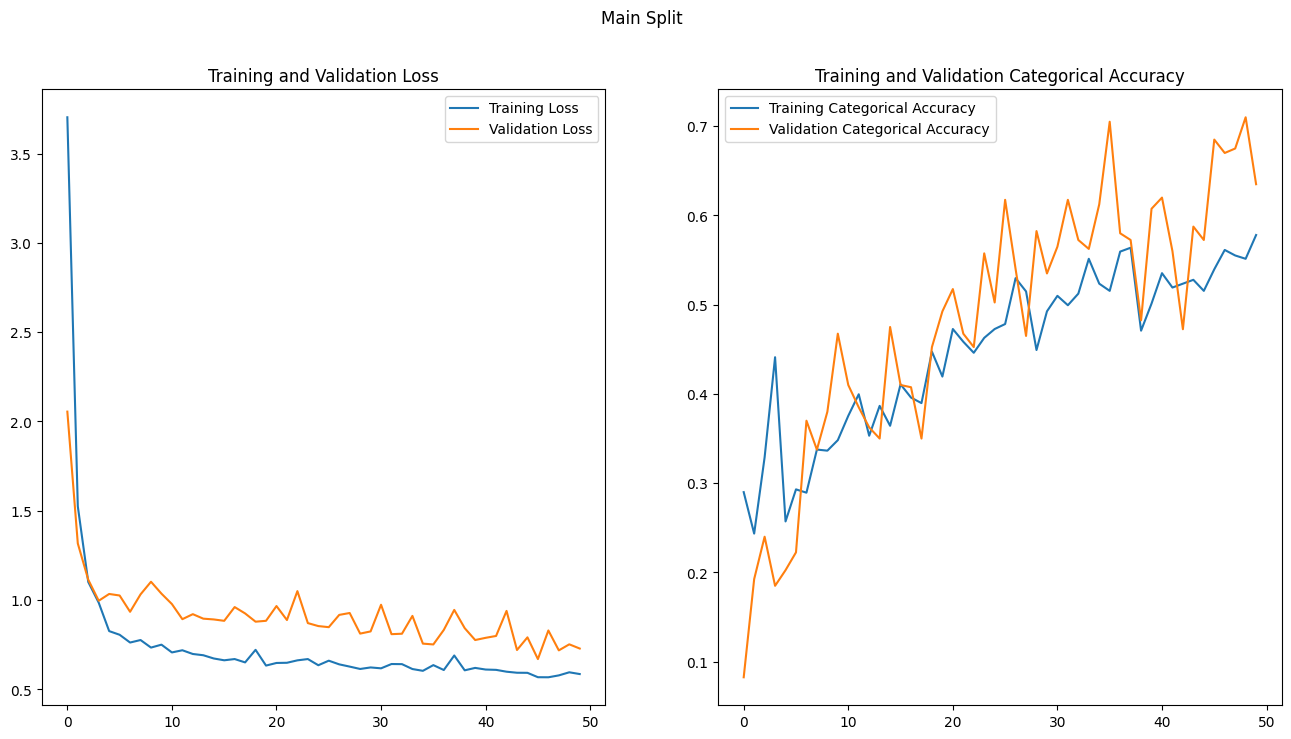

In [63]:
epochs_range = range(epochs)
rows = 1
cols = 2

loss = history.history['loss']
val_loss = history.history['val_loss']
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Main Split")
ax = fig.add_subplot(rows, cols, 1)
#ax.set_ylim(0, 3)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# CatCross = history.history['categorical_crossentropy']
# val_CatCross = history.history['val_categorical_crossentropy']
# ax = fig.add_subplot(rows, cols, 2)
# #ax.set_ylim(0, 3)
# plt.plot(epochs_range, CatCross, label='Training Categorical Crossentropy')
# plt.plot(epochs_range, val_CatCross, label='Validation Categorical Crossentropy')
# plt.legend(loc='upper left')
# plt.title('Training and Validation Categorical Crossentropy')

CatAcc = history.history['categorical_accuracy']
val_CatAcc = history.history['val_categorical_accuracy']
ax = fig.add_subplot(rows, cols, 2)
#ax.set_ylim(0, 3)
plt.plot(epochs_range, CatAcc, label='Training Categorical Accuracy')
plt.plot(epochs_range, val_CatAcc, label='Validation Categorical Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Categorical Accuracy')

plt.show()

#### Validation Answers

In [64]:
modelSplit.evaluate(x=[x_valid, x_valid_2], y=y_valid)

13/13 [==============================] - 1s 48ms/step - loss: 0.7287 - categorical_accuracy: 0.6350


[0.7287352085113525, 0.6349999904632568]

[[0.         0.         1.        ]
 [0.14911266 0.99999803 0.99999887]]
[[0.         0.         1.        ]
 [0.44121668 0.88052964 0.8653217 ]]
[[0.         0.         1.        ]
 [0.23195997 0.99988806 0.99991632]]


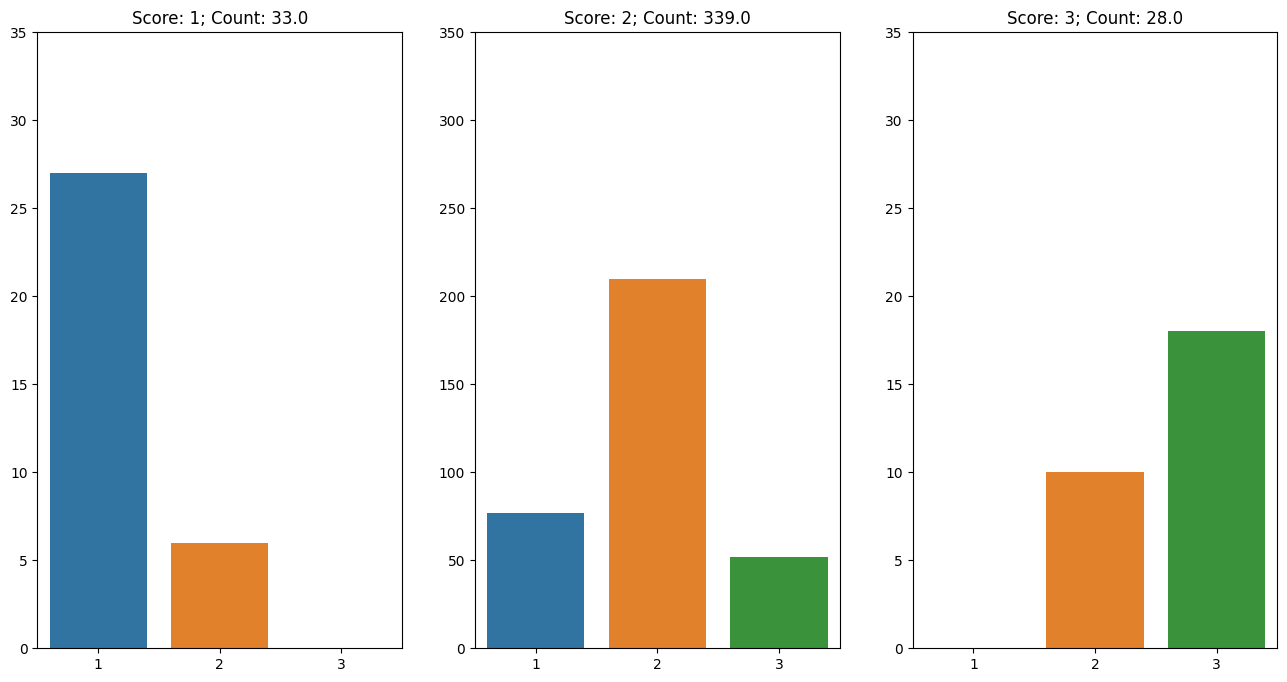

In [65]:
def GetCategoricalInfo(x: float):
    if x <= LOW_UPPER:
        return [1, 0, 0]
    elif x <= MED_UPPER:
        return [0, 1, 0]
    else:
        return [0, 0, 1]

test_predictions = np.zeros((len(x_valid), 2, 3))
for i in range(len(x_valid)):
    test_predictions[i][0] = y_valid[i]
    test_predictions[i][1] = modelSplit((np.expand_dims(x_valid[i], 0), x_valid_2[i]))

print(test_predictions[-2])
print(test_predictions[-1])
print(test_predictions[-3])

fig = plt.figure(figsize=(16, 8))
for i in range(0, 3, 1):
    count = np.zeros(3)

    for pred in test_predictions:
        if pred[0][i] == 1:
            count[np.argmax(pred[1])] += 1

    ax = fig.add_subplot(1, 3, i+1)

    if i == 1:
        ax.set_ylim((0,350))
    else:
        ax.set_ylim((0,35))

    sns.barplot(x=[x for x in range(1, 4)], y=count)
    plt.title(f'Score: {i+1}; Count: {count.sum()}')

plt.show()

## Low

#### Layer Creation

In [66]:
def Get_Low():
    input_shape_1 = x_train[0].shape
    input_shape_2 = x_train_2[0].shape
    print(input_shape_1)
    print(input_shape_2)

    input_1 = tf.keras.Input(shape=input_shape_1, dtype=np.float64)
    input_2 = tf.keras.Input(shape=input_shape_2, dtype=np.float64)

    layers_1 = tf.keras.layers.Normalization()(input_1)
    layers_1 = tf.keras.layers.Conv1D(filters=256, 
                                    kernel_size = (4,), 
                                    strides=2, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=256, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=100, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=80, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Flatten()(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=1024, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=4096, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=2048, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=512, activation='relu')(layers_1)
    model_1 = tf.keras.Model(inputs = input_1, outputs=layers_1)

    layers_2 = tf.keras.layers.Normalization()(input_2)
    layers_2 = tf.keras.layers.Dense(units=NUM_FEATURES_2, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dense(units=128, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=64, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=64, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=512, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.2)(layers_2)
    model_2 = tf.keras.models.Model(inputs = input_2, outputs=layers_2)

    layers_3 = tf.keras.layers.Dense(units=512, activation='relu')(tf.keras.layers.concatenate([model_1.output, model_2.output]))
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=128, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=256, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=512, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=256, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=12, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.2)(layers_3)
    
    layers_Output = tf.keras.layers.Dense(units=1,activation=tf.keras.activations.relu)(layers_3)
    return model_1.input, model_2.input, layers_Output

Low_Input_1, Low_Input_2, Low_Output = Get_Low()

modelLow = None
modelLow = tf.keras.models.Model(inputs=[Low_Input_1, Low_Input_2], outputs=Low_Output, name="Low")
modelLow.compile(optimizer='adam', loss=loss_Single, metrics=metrics_Single)
modelLow.summary()

(1800, 10)
(52,)


Model: "Low"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 1800, 10)]           0         []                            
                                                                                                  
 normalization_16 (Normaliz  (None, 1800, 10)             21        ['input_17[0][0]']            
 ation)                                                                                           
                                                                                                  
 conv1d_31 (Conv1D)          (None, 900, 256)             10496     ['normalization_16[0][0]']    
                                                                                                  
 max_pooling1d_31 (MaxPooli  (None, 450, 256)             0         ['conv1d_31[0][0]']         

#### Training

In [67]:
epochs = 120
historyLow = modelLow.fit(x=[x_train_low, x_train_low_2], y=y_train_low, validation_data=([x_valid_low, x_valid_low_2], y_valid_low), epochs=epochs)

Epoch 1/120
5/5 [==============================] - 1s 184ms/step - loss: 7.4902 - root_mean_squared_error: 1.6209 - val_loss: 6.4162 - val_root_mean_squared_error: 1.3731
Epoch 2/120
5/5 [==============================] - 1s 150ms/step - loss: 6.0704 - root_mean_squared_error: 1.2904 - val_loss: 6.2477 - val_root_mean_squared_error: 1.4500
Epoch 3/120
5/5 [==============================] - 1s 150ms/step - loss: 5.2523 - root_mean_squared_error: 1.1015 - val_loss: 4.8911 - val_root_mean_squared_error: 1.0446
Epoch 4/120
5/5 [==============================] - 1s 150ms/step - loss: 4.7288 - root_mean_squared_error: 1.0148 - val_loss: 5.3289 - val_root_mean_squared_error: 1.3623
Epoch 5/120
5/5 [==============================] - 1s 152ms/step - loss: 4.3168 - root_mean_squared_error: 0.9682 - val_loss: 4.4576 - val_root_mean_squared_error: 1.1345
Epoch 6/120
5/5 [==============================] - 1s 151ms/step - loss: 4.2452 - root_mean_squared_error: 1.0771 - val_loss: 4.4087 - val_root_m

#### Output

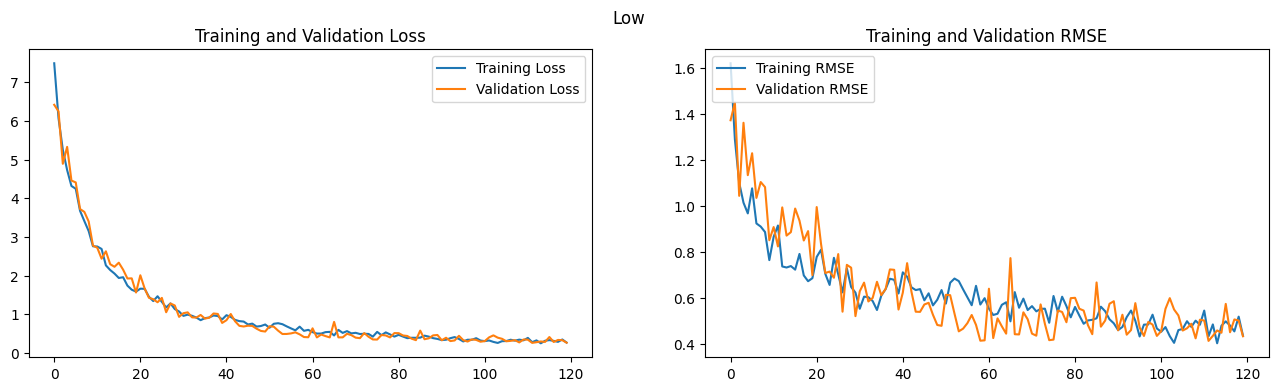

In [68]:
epochs_range = range(epochs)
rows = 1
cols = 2

loss = historyLow.history['loss']
val_loss = historyLow.history['val_loss']
fig = plt.figure(figsize=(16, 4))
fig.suptitle("Low")
ax = fig.add_subplot(rows, cols, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

RMSE = historyLow.history['root_mean_squared_error']
val_RMSE = historyLow.history['val_root_mean_squared_error']
ax = fig.add_subplot(rows, cols, 2)
plt.plot(epochs_range, RMSE, label='Training RMSE')
plt.plot(epochs_range, val_RMSE, label='Validation RMSE')
plt.legend(loc='upper left')
plt.title('Training and Validation RMSE')
plt.show()

## Medium

#### Layer Creation

In [69]:
def Get_Med():
    input_shape_1 = x_train[0].shape
    input_shape_2 = x_train_2[0].shape
    print(input_shape_1)
    print(input_shape_2)

    input_1 = tf.keras.Input(shape=input_shape_1, dtype=np.float64)
    input_2 = tf.keras.Input(shape=input_shape_2, dtype=np.float64)

    layers_1 = tf.keras.layers.Normalization()(input_1)
    layers_1 = tf.keras.layers.Conv1D(filters=256, 
                                    kernel_size = (4,), 
                                    strides=2, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=256, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=100, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=80, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Flatten()(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=1024, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=4096, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=2048, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=512, activation='relu')(layers_1)
    model_1 = tf.keras.Model(inputs = input_1, outputs=layers_1)

    layers_2 = tf.keras.layers.Normalization()(input_2)
    layers_2 = tf.keras.layers.Dense(units=NUM_FEATURES_2, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dense(units=128, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=64, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=64, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=512, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.2)(layers_2)
    model_2 = tf.keras.models.Model(inputs = input_2, outputs=layers_2)

    layers_3 = tf.keras.layers.Dense(units=512, activation='relu')(tf.keras.layers.concatenate([model_1.output, model_2.output]))
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=128, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=256, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=512, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=256, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=12, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.2)(layers_3)
    
    layers_Output = tf.keras.layers.Dense(units=1,activation=tf.keras.activations.relu)(layers_3)
    
    layers_Output = tf.keras.layers.Dense(units=1,activation=tf.keras.activations.relu)(layers_3)
    return model_1.input, model_2.input, layers_Output

Med_Input_1, Med_Input_2, Med_Output = Get_Low()

(1800, 10)
(52,)


In [70]:
modelMed = None
modelMed = tf.keras.models.Model(inputs=[Med_Input_1, Med_Input_2], outputs=Med_Output, name="Medium")
modelMed.summary()
modelMed.compile(optimizer='adam', loss=loss_Single, metrics=metrics_Single)

Model: "Medium"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 1800, 10)]           0         []                            
                                                                                                  
 normalization_18 (Normaliz  (None, 1800, 10)             21        ['input_19[0][0]']            
 ation)                                                                                           
                                                                                                  
 conv1d_35 (Conv1D)          (None, 900, 256)             10496     ['normalization_18[0][0]']    
                                                                                                  
 max_pooling1d_35 (MaxPooli  (None, 450, 256)             0         ['conv1d_35[0][0]']      

#### Training

In [71]:
epochs = 80
historyMed = modelMed.fit(x=[x_train_med, x_train_med_2], y=y_train_med, validation_data=([x_valid_med, x_valid_med_2], y_valid_med), epochs=epochs)

Epoch 1/80
40/40 [==============================] - 9s 187ms/step - loss: 9.7272 - root_mean_squared_error: 2.3698 - val_loss: 6.9395 - val_root_mean_squared_error: 1.9304
Epoch 2/80
40/40 [==============================] - 7s 182ms/step - loss: 5.9291 - root_mean_squared_error: 1.7722 - val_loss: 5.0635 - val_root_mean_squared_error: 1.6244
Epoch 3/80
40/40 [==============================] - 7s 183ms/step - loss: 4.7699 - root_mean_squared_error: 1.6098 - val_loss: 4.9091 - val_root_mean_squared_error: 1.7202
Epoch 4/80
40/40 [==============================] - 7s 185ms/step - loss: 4.2440 - root_mean_squared_error: 1.5693 - val_loss: 5.4086 - val_root_mean_squared_error: 1.9467
Epoch 5/80
40/40 [==============================] - 7s 184ms/step - loss: 3.5948 - root_mean_squared_error: 1.4493 - val_loss: 5.9763 - val_root_mean_squared_error: 2.1455
Epoch 6/80
40/40 [==============================] - 7s 186ms/step - loss: 3.2214 - root_mean_squared_error: 1.3958 - val_loss: 4.2678 - val_

#### Output

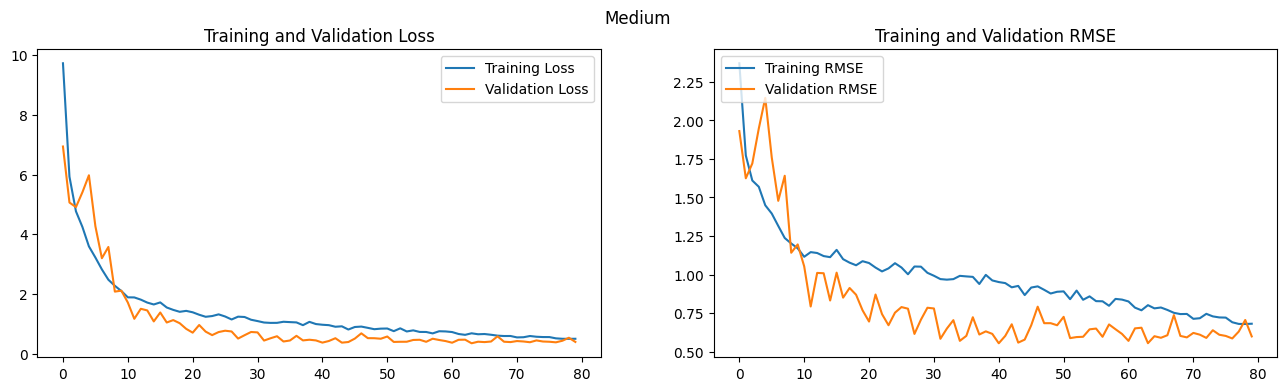

In [72]:
epochs_range = range(epochs)
rows = 1
cols = 2

loss = historyMed.history['loss']
val_loss = historyMed.history['val_loss']
fig = plt.figure(figsize=(16, 4))
fig.suptitle("Medium")
ax = fig.add_subplot(rows, cols, 1)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

RMSE = historyMed.history['root_mean_squared_error']
val_RMSE = historyMed.history['val_root_mean_squared_error']
ax = fig.add_subplot(rows, cols, 2)

plt.plot(epochs_range, RMSE, label='Training RMSE')
plt.plot(epochs_range, val_RMSE, label='Validation RMSE')
plt.legend(loc='upper left')
plt.title('Training and Validation RMSE')
plt.show()

## High

#### Layer Creation

In [73]:
def Get_High():
    input_shape_1 = x_train[0].shape
    input_shape_2 = x_train_2[0].shape
    print(input_shape_1)
    print(input_shape_2)

    input_1 = tf.keras.Input(shape=input_shape_1, dtype=np.float64)
    input_2 = tf.keras.Input(shape=input_shape_2, dtype=np.float64)

    layers_1 = tf.keras.layers.Normalization()(input_1)
    layers_1 = tf.keras.layers.Conv1D(filters=256, 
                                    kernel_size = (4,), 
                                    strides=2, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=256, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=100, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Conv1D(filters=80, 
                                    kernel_size = (4,), 
                                    strides=1, 
                                    padding="SAME", 
                                    activation='relu', 
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
                                    )(layers_1)
    layers_1 = tf.keras.layers.MaxPool1D()(layers_1)

    layers_1 = tf.keras.layers.Flatten()(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=1024, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=4096, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.4)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=2048, activation='relu')(layers_1)
    layers_1 = tf.keras.layers.Dropout(0.2)(layers_1)
    layers_1 = tf.keras.layers.Dense(units=512, activation='relu')(layers_1)
    model_1 = tf.keras.Model(inputs = input_1, outputs=layers_1)

    layers_2 = tf.keras.layers.Normalization()(input_2)
    layers_2 = tf.keras.layers.Dense(units=NUM_FEATURES_2, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dense(units=128, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=64, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=64, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.4)(layers_2)
    layers_2 = tf.keras.layers.Dense(units=512, activation='relu')(layers_2)
    layers_2 = tf.keras.layers.Dropout(0.2)(layers_2)
    model_2 = tf.keras.models.Model(inputs = input_2, outputs=layers_2)

    layers_3 = tf.keras.layers.Dense(units=512, activation='relu')(tf.keras.layers.concatenate([model_1.output, model_2.output]))
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=128, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=256, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=512, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=256, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.4)(layers_3)
    layers_3 = tf.keras.layers.Dense(units=12, activation='relu')(layers_3)
    layers_3 = tf.keras.layers.Dropout(0.2)(layers_3)
    
    layers_Output = tf.keras.layers.Dense(units=1,activation=tf.keras.activations.relu)(layers_3)
    return model_1.input, model_2.input, layers_Output

High_Input_1, High_Input_2, High_Output = Get_Low()

modelHigh = None
modelHigh = tf.keras.models.Model(inputs=[High_Input_1, High_Input_2], outputs=High_Output, name="High")
modelHigh.summary()
modelHigh.compile(optimizer='adam', loss=loss_Single, metrics=metrics_Single)

(1800, 10)
(52,)
Model: "High"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 1800, 10)]           0         []                            
                                                                                                  
 normalization_20 (Normaliz  (None, 1800, 10)             21        ['input_21[0][0]']            
 ation)                                                                                           
                                                                                                  
 conv1d_39 (Conv1D)          (None, 900, 256)             10496     ['normalization_20[0][0]']    
                                                                                                  
 max_pooling1d_39 (MaxPooli  (None, 450, 256)             0         ['conv1d_3

#### Training

In [74]:
epochs = 120
historyHigh = modelHigh.fit(x=[x_train_high, x_train_high_2], y=y_train_high, validation_data=([x_valid_high, x_valid_high_2], y_valid_high), epochs=epochs)

Epoch 1/120
4/4 [==============================] - 1s 190ms/step - loss: 102.5104 - root_mean_squared_error: 4.4805 - val_loss: 33.2261 - val_root_mean_squared_error: 5.3171
Epoch 2/120
4/4 [==============================] - 1s 146ms/step - loss: 25.9718 - root_mean_squared_error: 4.5873 - val_loss: 32.9276 - val_root_mean_squared_error: 5.2969
Epoch 3/120
4/4 [==============================] - 1s 146ms/step - loss: 23.6288 - root_mean_squared_error: 4.3340 - val_loss: 9.1420 - val_root_mean_squared_error: 2.0865
Epoch 4/120
4/4 [==============================] - 1s 148ms/step - loss: 19.1129 - root_mean_squared_error: 3.7878 - val_loss: 22.6436 - val_root_mean_squared_error: 4.2343
Epoch 5/120
4/4 [==============================] - 1s 145ms/step - loss: 15.1377 - root_mean_squared_error: 3.2321 - val_loss: 22.4983 - val_root_mean_squared_error: 4.2260
Epoch 6/120
4/4 [==============================] - 1s 145ms/step - loss: 15.7113 - root_mean_squared_error: 3.3309 - val_loss: 22.3482 

#### Output

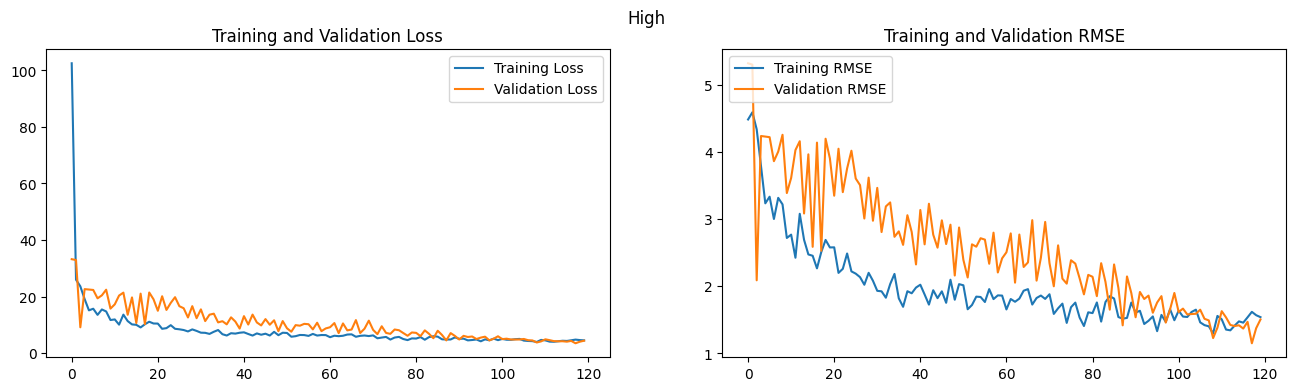

In [75]:
epochs_range = range(epochs)
rows = 1
cols = 2

loss = historyHigh.history['loss']
val_loss = historyHigh.history['val_loss']
fig = plt.figure(figsize=(16, 4))
fig.suptitle("High")
ax = fig.add_subplot(rows, cols, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

RMSE = historyHigh.history['root_mean_squared_error']
val_RMSE = historyHigh.history['val_root_mean_squared_error']
ax = fig.add_subplot(rows, cols, 2)
plt.plot(epochs_range, RMSE, label='Training RMSE')
plt.plot(epochs_range, val_RMSE, label='Validation RMSE')
plt.legend(loc='upper left')
plt.title('Training and Validation RMSE')
plt.show()

## Evalutaion

##### Functions

In [76]:
def OneColdCode(arr: list) -> float:
    score = 0.5
    max_score = 0.5
    highests = 0
    for i in arr:
        if i >= highests:
            highests = i
            max_score = score
        score += 0.5
    return max_score

def HalfRound(a: float) -> float:
    return round(a * 2) / 2.0

def SinglOutputProcessing(a: float) -> float:
    a = float(a)
    a = HalfRound(a)

    if a < 0.5:
        a = 0.5
    if a > 6.0:
        a = 6.0

    return a

In [77]:
def GetPrediction(x_1: np.array, x_2: np.array) -> float:
    result = 3.5
    #try:
    CatPred = modelSplit((x_1, x_2))
    maxIndex = 0
    maxPred = 0
    for i, a in enumerate(CatPred[0]):
        if a > maxPred:
            maxPred = a
            maxIndex = i
    
    match maxIndex:
        case 0:
            result = modelLow([x_1, x_2])
        case 1:
            result = modelMed([x_1, x_2])
        case 2:
            result = modelHigh([x_1, x_2])
    result = SinglOutputProcessing((result[0][0]))
    #except Exception as ex:
    #    print(f"ERROR: {ex}")
    #finally:
    return result

#### Testing Evaluation

Score: 0.9984988733093293


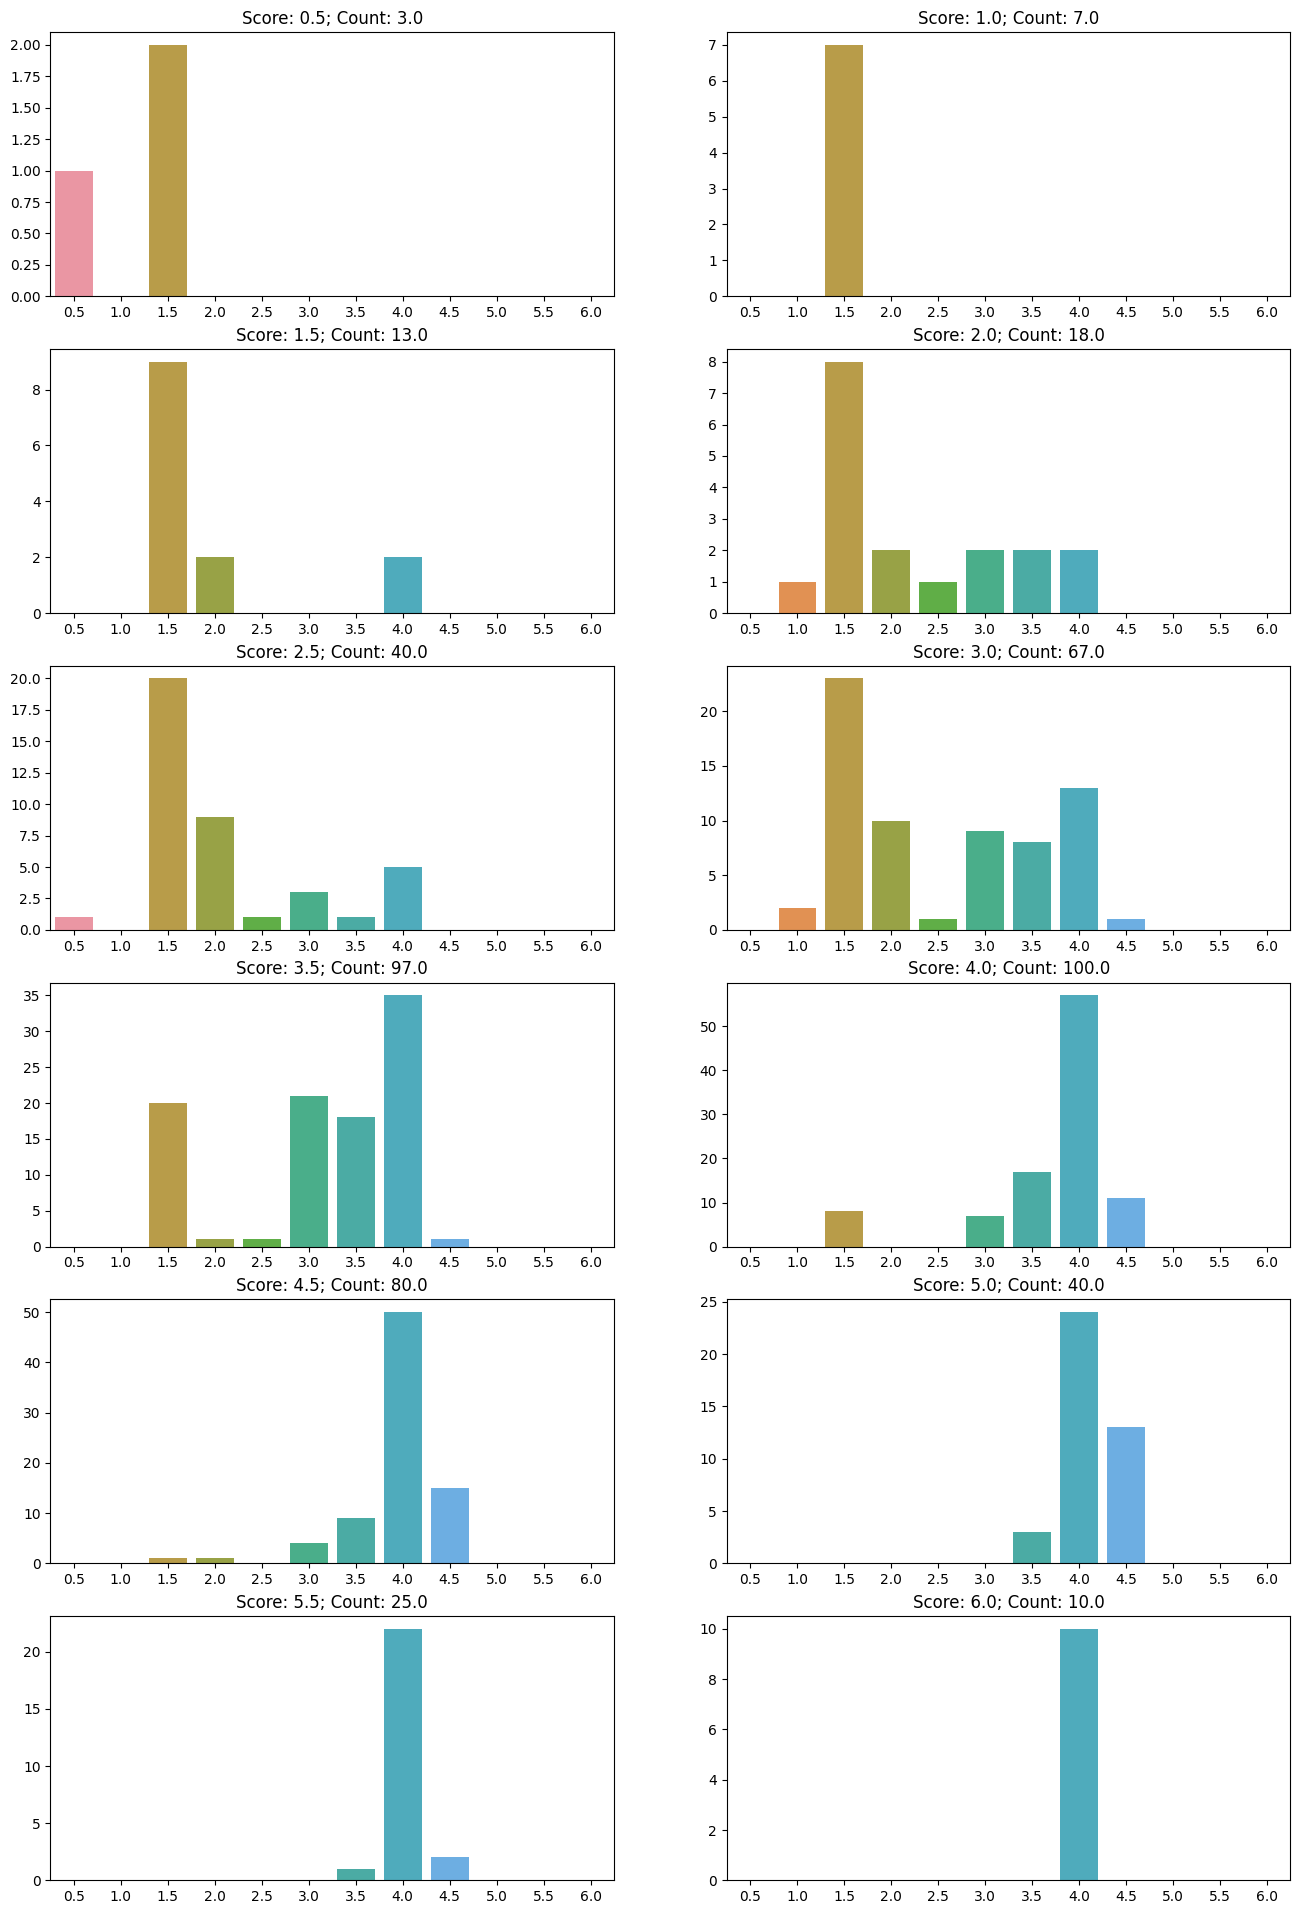

In [78]:
# TODO: Show graphs of the validation data and then have a seperate test one. This is to avoid
#       overfitting via make decisions based on the test set.

test_predictions = np.zeros((len(x_test), 2))
for i in range(len(x_test)):
    test_predictions[i][0] = y_test[i]
    test_predictions[i][1] = GetPrediction(np.expand_dims(x_test[i], 0), x_test_2[i])

fig = plt.figure(figsize=(16, 24))
for i in range(1, 13, 1):
    count = np.zeros(12)

    for pred in test_predictions:
        if pred[0] * 2 == i:
            count[int(pred[1]*2) - 1] += 1

    fig.add_subplot(6, 2, i)
    sns.barplot(x=[x/2 for x in range(1, 13)], y=count)
    plt.title(f'Score: {i/2}; Count: {count.sum()}')

score = 0
for pred in test_predictions:
    score += (pred[0] - pred[1])**2

score /= len(test_predictions)
print(f"Score: {sqrt(score)}")

plt.show()

## Predictions

In [79]:
# 2c75e15a --> 4.0
# 2c7997a3 --> 3.5
# 2d299968 --> 5.0
#test_logs = pd.read_csv("./data/personaltest.csv")

predictions = []
for id in test_logs["id"].unique():
    pred_score = 3.5
    try:
        x_test, x_test_2, y_test = DfToX(test_logs[test_logs["id"] == id])
        pred = model.predict((x_test, x_test_2))
        pred_score = OneColdCode(pred[0])
        #pred_score = HalfRound(pred[0][0])
        #pred_score = pred[0][0]
    except ValueError as ex:
        pred_score = 3.5
        print(f"VALUE ERROR OCCURED. ERROR: {ex}")
    except Exception as ex:
        print(f"ERROR: {ex}")
        pred_score = 3.5
    finally:
        predictions.append((id, pred_score))

ids = [p[0] for p in predictions]
scores = [p[1] for p in predictions]

sample_submission["id"] = ids
sample_submission["score"] = scores
sample_submission[["id", "score"]].to_csv("submission.csv", index=False)

ERROR: name 'model' is not defined
ERROR: name 'model' is not defined
ERROR: name 'model' is not defined
